In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
from pathlib import Path
from sqlalchemy import Column, Integer, String, Float



In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")




In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare (autoload_with=engine)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
recent_date

'2017-08-23'

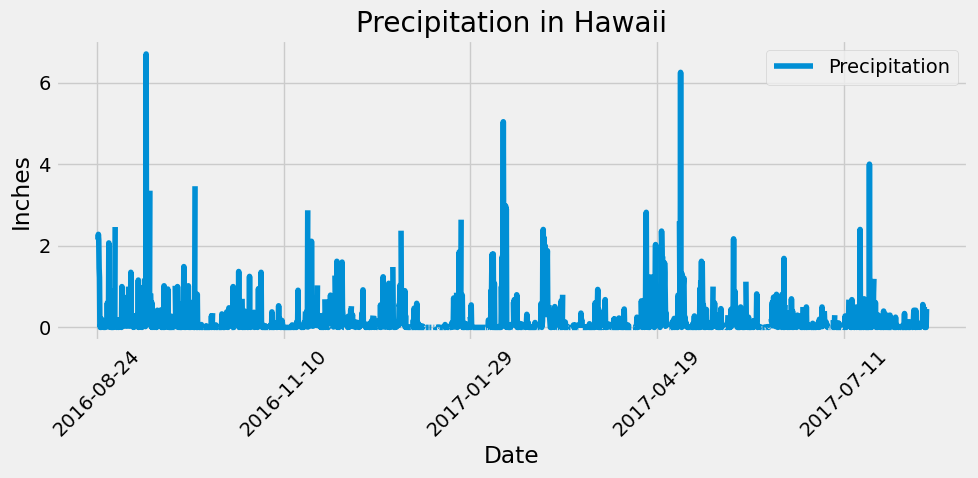

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#convert the string to a date
if isinstance(recent_date, str):
    recent_date = datetime.strptime(recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
one_year_ago = recent_date-timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', kind='line', figsize=(10,5), linestyle = '-')

plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in Hawaii')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(func.count(station.id)).scalar()

stations_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations
most_active_stations = session.query(
    measurement.station, 
    func.count(measurement.station).label('count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_subquery = session.query(
    measurement.station,
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).limit(1).subquery()

# Query to find lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(measurement.tobs).label ('min_temp'),
    func.max(measurement.tobs).label ('max_temp'),
    func.avg(measurement.tobs).label ('avg_temp')
).filter(measurement.station == most_active_subquery.c.station).one()

min_temp, max_temp, avg_temp = temperature_stats

temperature_stats


(54.0, 85.0, 71.66378066378067)

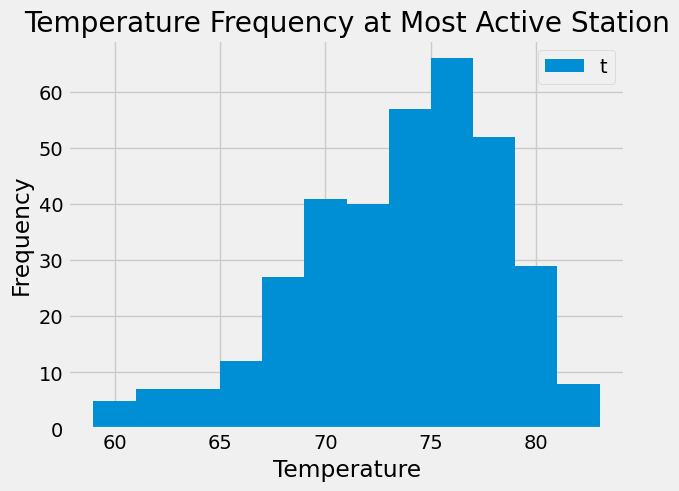

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most active station ID
most_active_station_id = session.query(measurement.station).\
    group_by(measurement.station).\
    order_by(desc(func.count(measurement.station))).\
    first()[0]

# Data for one year before most recent data
most_recent_data = session.query(func.max(measurement.date)).scalar()
if isinstance(most_recent_data,str):
    most_recent_date = datetime.strptime(most_recent_data, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Query to get temperature data for most active station
temp_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()
           
# Convert to list of temps
temperatures = [temp[0] for temp in temp_data]


# Plot histogram
plt.hist(temperatures, bins = 12)
plt.legend ('tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Frequency at Most Active Station')
plt.show()


# Close Session

In [16]:
# Close Session
session.close()